In [220]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [6]:
#read drug list
# Read the Excel file
metadata = pd.read_excel('dataset/med_kaggle/drug list.xlsx')

print(metadata.head())

   Index       Name    Dose    Size     Type
0      1    Acretin   0.05%    30 g    cream
1      2       Adol  500 mg      24  caplets
2      3     Aggrex   75 mg      60  tablets
3      4  Airoplast    5 cm     NaN     Tape
4      5   All-Vent     NaN  125 ml    syrup


In [17]:
uni_name = metadata['Name'].unique()
print("unique name: ", len(uni_name))

uni_type = metadata['Type'].unique()
print("unique name: ", len(uni_type))
print(uni_type)

unique name:  141
unique name:  32
['cream' 'caplets' 'tablets' 'Tape' 'syrup' 'capsules' 'spray solution'
 'sachets' 'solution' 'ointment' 'mouth wash' 'spray' nan 'Vial'
 'oral suspension' 'repetabs' 'gel' 'oral drops' 'gel oral' 'colic drops'
 'capsule' 'emulsion' 'spansules' 'nasal spray' 'hydrogel' 'oral gel'
 'liquid' 'ear drops' 'chewable tablets' 'paint' 'eye drops'
 'oral inhalation']


In [207]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # Root directory containing all classes
        self.transform = transform  # Transformation for images

        # List all image files in the dataset
        self.img_list = []
        self.name_to_idx = {}
        self.type_to_idx = {}

        # List of class directories (which will be used for one-hot encoding)
        self.classes = sorted(os.listdir(root_dir))  # Assuming directories are the class names

        for name in self.classes:
            class_folder = os.path.join(root_dir, name)
            if os.path.isdir(class_folder):
                # Split the folder name into `name` and `type`
                parts = name.split()  # Assuming space separates name and type
                if len(parts) >= 2:
                    name_part = parts[0]  # First part is the name
                    type_part = parts[-1]  # Last part is the type
                    self.name_to_idx[name_part] = len(self.name_to_idx)
                    self.type_to_idx[type_part] = len(self.type_to_idx)
                    for img_name in os.listdir(class_folder):
                        img_path = os.path.join(class_folder, img_name)
                        self.img_list.append((img_path, name_part, type_part))  # Add image path and class name/type
        # print(self.img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path, name_part, type_part = self.img_list[idx]
        
        img = Image.open(img_path).convert("RGB")  # Open image
        
        # One-hot encode Name and Type
        name_encoded = self.encode_name(name_part)
        type_encoded = self.encode_type(type_part)
        
        # Combine the encoded labels into a single tensor
        labels = torch.cat((name_encoded, type_encoded))
        
        if self.transform:
            img = self.transform(img)

        return img, labels

    def encode_name(self, name):
        # One-hot encode Name (class_name as Name)
        one_hot = torch.zeros(len(self.name_to_idx))
        idx = self.name_to_idx[name]
        one_hot[idx] = 1
        return one_hot

    def encode_type(self, type):
        # One-hot encode Type (class_name as Type)
        one_hot = torch.zeros(len(self.type_to_idx))
        idx = self.type_to_idx[type]
        one_hot[idx] = 1
        return one_hot


In [226]:
# Define some sample transformations
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
root_dir = 'dataset/med_kaggle/img'  # Update with your actual directory
dataset = MultiLabelDataset(root_dir=root_dir, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
# Create a DataLoader to load data in batches
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.9776908].


Image batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4, 10])
['Acretin', 'Adol', 'Aggrex', 'Airoplast', 'All-Vent']
['cream', 'caplets', 'tablets', 'Tape', 'syrup']


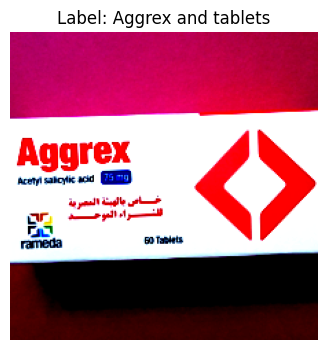

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].


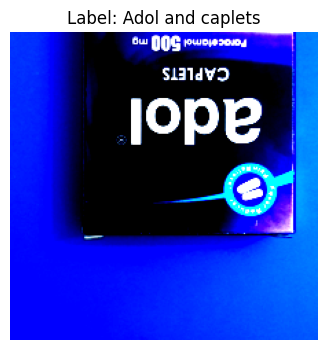

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.9602616].


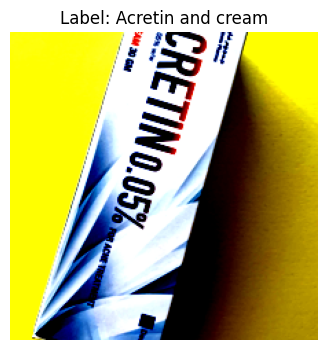

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.4722441].


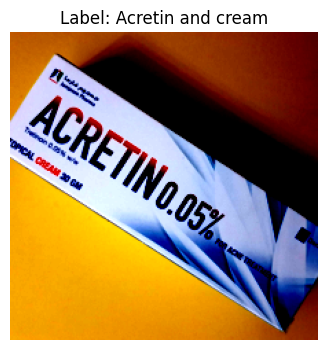

In [218]:


# Iterate through the DataLoader and check the results
for img, labels in train_loader:
    print(f'Image batch shape: {img.shape}')
    print(f'Labels batch shape: {labels.shape}')
    
    # Get the class directories (same as self.classes)
    name_classes = list(dataset.name_to_idx.keys())  # List of name classes
    type_classes = list(dataset.type_to_idx.keys())  # List of type classes
    
    print(name_classes)
    print(type_classes)
    # Assuming `labels` is the one-hot encoded tensor (shape: [batch_size, 2 * num_classes])
    for i in range(labels.shape[0]):  # Iterate through each image in the batch
        label = labels[i]
        
        # Reverse the one-hot encoding for name (first half of the label vector)
        name_one_hot = label[:len(name_classes)]  # First part corresponds to name
        name_idx = torch.argmax(name_one_hot)  # Find the index for "name"
        
        # Reverse the one-hot encoding for type (second half of the label vector)
        type_one_hot = label[len(name_classes):]  # Second part corresponds to type
        type_idx = torch.argmax(type_one_hot)  # Find the index for "type"
        
        # Get the human-readable class names
        name = name_classes[name_idx]  # The "name" class (from name_to_idx)
        type_ = type_classes[type_idx]  # The "type" class (from type_to_idx)
        
        # Get the image and convert it back to numpy for display
        img_to_show = img[i].permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
        
        # Plot the image and label
        plt.figure(figsize=(4, 4))
        plt.imshow(img_to_show)
        plt.title(f"Label: {name} and {type_}")
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()

    break  # Check only one batch for now

In [221]:
# Get pretrained model using torchvision.models as models library
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

/Users/baiporthn/.pyenv/versions/3.9.13/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/baiporthn/.pyenv/versions/3.9.13/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /Users/baiporthn/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:11<00:00, 10.1MB/s] 


In [223]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features
print(classifier_input)
num_labels = 10
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
model.classifier = classifier

2208


In [224]:
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [228]:
# Set the error function using torch.nn as nn library
criterion = nn.MSELoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

In [232]:
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26


RuntimeError: shape '[4, 1]' is invalid for input of size 40

In [78]:
t = ['Acretin 30 g cream', 'Adol 24 caplets', 'Aggrex 60 tablets', 'Airoplast nan Tape', 'All-Vent 125 ml syrup']
name = []
type = []
for i in t:
    z = i.split()
    name.append(z[0])
    type.append(z[-1])

print(type)
print(name)

['cream', 'caplets', 'tablets', 'Tape', 'syrup']
['Acretin', 'Adol', 'Aggrex', 'Airoplast', 'All-Vent']


In [48]:
dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4